In [2]:
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as ocm
from scipy import stats
from scipy.signal import detrend
import pandas as pd
import pickle
from scipy import fftpack

proj_dir = '/home/ubuntu/bigStick/antarctic_melting'
data_dir = os.path.join(proj_dir,'data','analysis')
raw_dir = os.path.join(data_dir,'raw')
int_dir = os.path.join(data_dir,'interim')
fig_dir = os.path.join(proj_dir,'reports','tidal_melting','figures')
tab_dir = os.path.join(proj_dir,'reports','tidal_melting','tables')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)
tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)

%load_ext autoreload
%autoreload 2

from pySSA.mySSA import mySSA
from log_progress import log_progress
from rotate_vector_roms import rotate_vector_roms
from make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves

In [4]:
file_path = os.path.join(raw_dir,'scratch','waom4','ocean_avg_0010.nc')
tides = xr.open_dataset(file_path)#,chunks={'xi_rho':75,'eta_rho':75})
file_path = os.path.join(raw_dir,'scratch','waom4_nt','ocean_avg_0010.nc')
no_tides = xr.open_dataset(file_path)#,chunks={'xi_rho':75,'eta_rho':75})
grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)

mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500) 
mask_shelf['Total Antarctica'][1050:1140,95:113] = True
mask_shelf['Total Antarctica'][:,1500:] = False

grd.mask_rho[570:610,1030:1140] = False

In [20]:
sel = {'xi_rho' : slice(350,650),'eta_rho' : slice(700,950),
           'xi_u' : slice(350,649),'eta_u' : slice(700,950),
           'xi_v' : slice(350,650),'eta_v' : slice(700,949)}
FRIS = tides.isel(sel)
FRIS_nt = no_tides.isel(sel)
rho_sel = {'xi_rho' : slice(350,650),'eta_rho' : slice(700,950)}
FRIS_mask = ((grd.mask_rho==1) & (mask_shelf['Total Antarctica']==1)).isel(rho_sel)

In [7]:
def get_uv_rho(u,v,mask):
    u_rho = np.zeros((u.ocean_time.size,mask.eta_rho.size,mask.xi_rho.size))
    v_rho = np.zeros_like(u_rho)
    for i in log_progress(range(u.ocean_time.size)):
        u_rho[i],v_rho[i] = rotate_vector_roms(u[i,:,:].values,v[i,:,:].values,np.zeros_like(mask))
    u_rho = xr.DataArray(u_rho,dims=('ocean_time','eta_rho','xi_rho')).where(mask)
    v_rho = xr.DataArray(v_rho,dims=('ocean_time','eta_rho','xi_rho')).where(mask)
    return u_rho,v_rho

def loop_sqrt(u,v):
    ustar = u.copy()
    for i in log_progress(range(u.ocean_time.size)):
        ustar[i]=np.sqrt(np.sqrt(u[i]**2+v[i]**2))
    return ustar

def get_ustar(ds,mask):
    print('getting sustr_rho, svstr_rho')
    sustr_rho,svstr_rho = get_uv_rho(ds.sustr,ds.svstr,mask)
    #sustr_rho.to_netcdf(os.path.join(int_dir,'sustr_rho_nt.nc'))
    #svstr_rho.to_netcdf(os.path.join(int_dir,'svstr_rho_nt.nc'))
    #sustr_rho = xr.open_dataarray(os.path.join(int_dir,'sustr_rho.nc'))
    #svstr_rho = xr.open_dataarray(os.path.join(int_dir,'svstr_rho.nc'))
    sustr_rho['ocean_time']=ds.svstr.ocean_time
    svstr_rho['ocean_time']=ds.svstr.ocean_time
    return loop_sqrt(sustr_rho,svstr_rho)

In [8]:
FRIS_nt['ustar_post']=get_ustar(FRIS_nt,FRIS_mask)

getting sustr_rho, svstr_rho


In [9]:
FRIS['ustar_post']=get_ustar(FRIS,FRIS_mask)

getting sustr_rho, svstr_rho


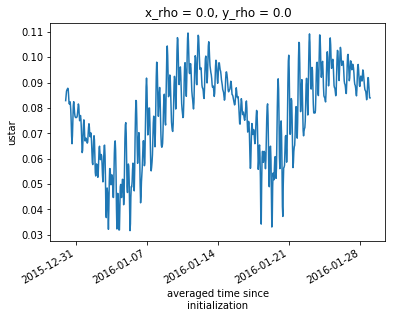

In [14]:
FRIS.ustar[:,100,100].plot()

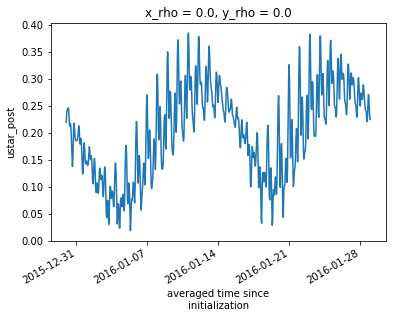

In [13]:
FRIS.ustar_post[:,100,100].plot()

In [5]:
dyn = ((FRIS.ustar-FRIS_nt.ustar)*FRIS_nt.Tstar).mean('ocean_time')

AttributeError: 'Dataset' object has no attribute 'ustar'

# calc or get ustar (tides and no_tides)

# calc individ components

In [14]:
def plot_m(ax,da,text):
    da.plot(ax=ax,vmin=-da.std()*2,vmax=da.std()*2,cmap=ocm.balance,cbar_kwargs={'label': 'u*T* in m/s*degC'})
    ax = make_text(ax,text)
    return ax

def make_text(ax,text):
    ax.text(0.5, 0.5, text, horizontalalignment='center',verticalalignment='center',
                   transform=ax.transAxes,size=14)
    return ax

In [21]:
from dask.distributed import Client
C = Client()
chunks = {'xi_rho':100,'eta_rho':100}

FRIS = FRIS.chunk(chunks)
FRIS_nt = FRIS_nt.chunk(chunks)

In [22]:
dyn = ((FRIS.ustar-FRIS_nt.ustar)*FRIS_nt.Tstar).where(FRIS_mask).mean('ocean_time').load()
print('ping')
therm = ((FRIS.Tstar-FRIS_nt.Tstar)*FRIS_nt.ustar).where(FRIS_mask).mean('ocean_time').load()
print('ping')
cov = ((FRIS.ustar-FRIS_nt.ustar)*(FRIS.Tstar-FRIS_nt.Tstar)).where(FRIS_mask).mean('ocean_time').load()
print('ping')
dMstar = ((FRIS.ustar*FRIS.Tstar).where(FRIS_mask).mean('ocean_time')-
          (FRIS_nt.ustar*FRIS_nt.Tstar).where(FRIS_mask).mean('ocean_time')).load()

ping
ping
ping


In [23]:
a = (therm+cov+dyn).load()

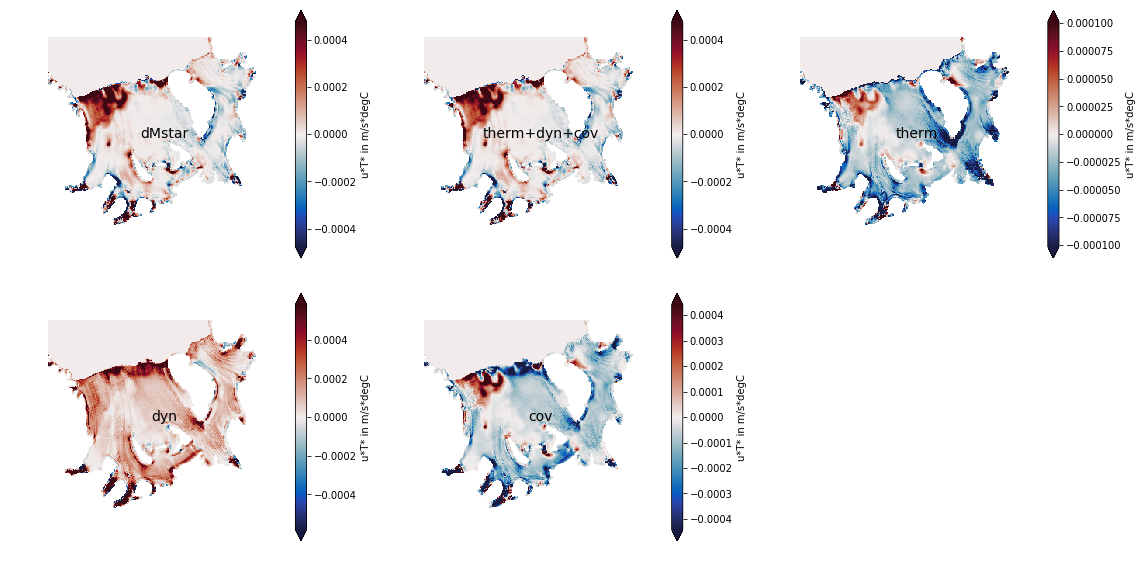

In [24]:
fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(16,8))
ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()

ax1 = plot_m(ax1,dMstar,'dMstar')
ax2 = plot_m(ax2,a,'therm+dyn+cov')
ax3 = plot_m(ax3,therm,'therm')
ax4 = plot_m(ax4,dyn,'dyn')
ax5 = plot_m(ax5,cov,'cov')

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.tight_layout()
plt.show()